In [8]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader, ConcatDataset
from sklearn.preprocessing import StandardScaler

import os
import numpy as np
import torch
from torch.utils.data import Dataset


In [2]:
import glob
import gc
def get_files(fpath,extension):
    files = glob.glob(f"{fpath}*.{extension}")
    return files

import os
def select_files_with_tr(directory, tr_number):
    selected_files = []
    for filename in os.listdir(directory):
        if tr_number in filename:
            full_path = os.path.join(directory, filename)
            selected_files.append(full_path)

    return selected_files

def get_all_files_except_selected(directory, selected_files):
    all_files = get_files(directory, 'npy')
    other_files = [f for f in all_files if f not in selected_files]
    return other_files
directory = '/home/xinyu/TremorProject/data/patient12_train/'
tr_number = 'TR007'

# Get the list of selected files
test_files = select_files_with_tr(directory, tr_number)

train_files = get_all_files_except_selected(directory, test_files)

In [1]:
import glob
import gc
import os
def select_files_with_tr(directory, tr_number, nontremor = False):
    selected_files = []
    for filename in os.listdir(directory):
        if nontremor:
            if tr_number in filename and 'nontremor' not in filename:
                full_path = os.path.join(directory, filename)
                selected_files.append(full_path)
        elif    tr_number in filename :
                full_path = os.path.join(directory, filename)
                selected_files.append(full_path)

    return selected_files
train_path = '/home/xinyu/TremorProject/data/patient12_train/'
test_path = '/home/xinyu/TremorProject/data/Cwt_nontremor_data/'
tr_number = 'TR004'

def get_files(fpath,extension):
    files = glob.glob(f"{fpath}*.{extension}")
    return files

def get_train_files(all_files, test_files):
    return [file for file in all_files if file not in test_files]

pid_files = select_files_with_tr(train_path, tr_number)
test_files_tremor = select_files_with_tr(train_path, tr_number, True)
test_files_nontremor = select_files_with_tr(test_path, tr_number)

test_files = test_files_tremor + test_files_nontremor

all_files = get_files(train_path,'npy')

train_files = get_train_files(all_files, pid_files)


In [2]:
test_files

['/home/xinyu/TremorProject/data/patient12_train/Copy of Copy of TR004_phase1_20190328123319_tremor.npy',
 '/home/xinyu/TremorProject/data/patient12_train/Copy of Copy of TR004_phase2_20190328130247_tremor.npy',
 '/home/xinyu/TremorProject/data/patient12_train/Copy of Copy of TR004_phase2_20190328125705_tremor.npy',
 '/home/xinyu/TremorProject/data/patient12_train/Copy of Copy of TR004_phase3_20190328131736_tremor.npy',
 '/home/xinyu/TremorProject/data/patient12_train/Copy of Copy of TR004_phase3_20190328132159_tremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR004_phase2_20190328125705_nontremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR004_phase3_20190328132159_nontremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR004_phase1_20190328123319_nontremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR004_phase2_20190328130247_nontremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR004_phase3_20190328131736_nontre

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class NpyDataset2(Dataset):
    def __init__(self, file_path,transform=None):
        self.data = np.load(file_path, mmap_mode='r')
        self.num_samples = self.data.shape[0]
        self.file_name = os.path.basename(file_path)
        self.transform = transform
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        data_point =np.abs(self.data[idx])
        label = 0 if 'nontremor' in self.file_name else 1  # Example label logic
        if self.transform:
            data_point = self.transform(data_point)
        return torch.tensor(data_point, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [9]:

class NormalizeToZeroOne:
    def __call__(self, x):
        x_min = x.min()
        x_max = x.max()
        return (x - x_min) / (x_max - x_min)

class StandardScale:
    def __init__(self):
        self.scaler = StandardScaler()

    def __call__(self, x):
        # Convert tensor to NumPy array and reshape if needed
        x_np = x.numpy() if isinstance(x, torch.Tensor) else x
        print(x_np.shape)
        x_np = x_np.reshape(8, 128*128)  # Reshape to (batch_size, num_features)
        
        # Fit scaler on the input data
        self.scaler.fit(x_np)

        # Transform and return as PyTorch tensor
        x_scaled = self.scaler.transform(x_np)
        return x_scaled.reshape(8,128,128)
    
batch_size=64
# Load datasets with the normalization transform
transform = NormalizeToZeroOne()

datasets = [NpyDataset2(file_path, transform=None) for file_path in train_files]
concat_dataset = ConcatDataset(datasets)

train_loader = DataLoader(concat_dataset , batch_size=64, shuffle=True)


datasets = [NpyDataset2(file_path, transform=transform) for file_path in test_files]
concat_dataset = ConcatDataset(datasets)

test_loader = DataLoader(concat_dataset , batch_size=64, shuffle=False)

In [10]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split
datasets = [NpyDataset2(file_path, transform=transform) for file_path in train_files]

def create_proportional_subset(dataset, percentage):
    num_samples = len(dataset)
    subset_indices = np.random.choice(num_samples, int(num_samples * percentage), replace=False)
    return Subset(dataset, subset_indices), subset_indices

def create_test_set(dataset, train_indices):
    all_indices = np.arange(len(dataset))
    test_indices = np.setdiff1d(all_indices, train_indices)
    return Subset(dataset, test_indices)

data_percentage = 1

# Create proportional subsets for each dataset and corresponding test sets
train_subsets = []
test_subsets = []

for dataset in datasets:
    train_subset, train_indices = create_proportional_subset(dataset, data_percentage)
    test_subset = create_test_set(dataset, train_indices)
    train_subsets.append(train_subset)
    test_subsets.append(test_subset)
concat_train_dataset = ConcatDataset(train_subsets)
concat_test_dataset = ConcatDataset(test_subsets)

train_size = int(len(concat_train_dataset) * 0.01)
valid_size = len(concat_train_dataset) - train_size  # Remaining 20% for testing

# Split train_subset into training and testing subsets
train_dataset, valid_subset = random_split(concat_train_dataset, [train_size, valid_size])

# Create DataLoader for each subset dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
valid_loader = DataLoader(concat_test_dataset, batch_size=batch_size, shuffle=False) 


In [11]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # CNN expects input of shape (batch_size, channels, height, width)
        x = self.cnn(x)
        # Reshape for LSTM input: (batch_size, seq_len, input_size)
        x = x.view(x.size(0), -1, 128)

        # LSTM forward pass
        out, _ = self.lstm(x)
        embeddings = out[:, -1, :]


        out = self.fc(out[:, -1, :])
        return out, embeddings

In [12]:
class MLP(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(MLP, self).__init__()
        self.input_shape = input_shape
        self.flattened_dim = input_shape[0] * input_shape[1] * input_shape[2]
        
        self.fc1 = nn.Linear(self.flattened_dim, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
       
        x = x.view(x.size(0), -1)  # Flatten the input from (batch_size, 8, 128, 128) to (batch_size, 8*128*128)
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
       
        return torch.sigmoid(x)


In [12]:
## choose cpu or gpu
seed = 1
torch.manual_seed(seed)
## choose GPU id
gpu_id = 1  ## 1, 2, 3,4
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device('cuda', gpu_id)
else:
    device = torch.device('cpu')
print("device: ", device)
## random seed for cuda
if use_cuda:
    torch.cuda.manual_seed(72)

batch_size = 64
channels = 8
height, width = 128, 128
num_classes = 1 # Adjust based on the number of classes in your problem

# Create the model
model = MLP(input_shape=(channels, height, width), num_classes=num_classes).to(device)

# Print the model architecture
print(model)

device:  cuda:1


NameError: name 'MLP' is not defined

In [13]:
def _compute_counts(y_pred, y_batch, mode='train'):
    return (y_pred==y_batch).sum().item()

In [14]:
def _save_checkpoint(ckp_path, model, epoch, optimizer, global_step):
    ## save checkpoint to ckp_path: 'checkpoint/step_100.pt'
    ckp_path = ckp_path + 'ckp_{}.pt'.format(epoch+1)
    checkpoint = {'epoch': epoch,
                  'global_step': global_step,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, ckp_path)

In [15]:

hidden_size = 128
num_layers = 2
num_classes = 1  # Assuming binary classification

model = CNN_LSTM(hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
model.to(device)

CNN_LSTM(
  (cnn): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [15]:
datasets = [NpyDataset2(file_path, transform=transform) for file_path in test_files]
concat_dataset = ConcatDataset(datasets)

loo_loader = DataLoader(concat_dataset , batch_size=64, shuffle=False)

In [16]:
from torch.autograd import Variable
def train( model, epochs, device, x_dim=784):
        
    ## initialize hyper-parameters
    num_epoches = 40
    decay = 0.01
    learning_rate = 0.005
    batch_size = 64
    ckp_path = '/home/xinyu/TremorProject/code/checkpoint/lstm_0.005_p4/'
    if not os.path.exists(ckp_path):
        os.makedirs(ckp_path)

    optimizer = optim.Adam(model.parameters(),lr=learning_rate)  ## optimizer
    loss_fun = nn.BCEWithLogitsLoss()  ## cross entropy loss


    iteration = 0
    if True:
        model = model.train() ## model training
        for epoch in range(num_epoches): #10-50
            ## learning rate
            # adjust_learning_rate(learning_rate, optimizer, epoch, decay)
            for batch_id, (x_batch,y_labels) in enumerate(train_loader):
                y_labels = y_labels.long()
                iteration += 1
                x_batch,y_labels = Variable(x_batch).to(device), Variable(y_labels).to(device)

                ## feed input data x into model
                output_y,_ = model(x_batch)

                y_labels = y_labels.float()
                loss = loss_fun(output_y, y_labels.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step() # update params

                y_pred = (output_y > 0.5).float()
                y_pred = y_pred.view(-1)

                accy = _compute_counts(y_pred, y_labels)/batch_size
                ##----------------------------------------------------------
                ## Step 7: print loss values [I have done it]
                ##----------------------------------------------------------
                if iteration%10==0:
                    print('iter: {} loss: {}, accy: {}'.format(iteration, loss.item(), accy))
                    # wandb.log({'iter': iteration, 'loss': loss.item()})
                    # wandb.log({'iter': iteration, 'accy': accy})

            _save_checkpoint(ckp_path, model, epoch, optimizer, iteration)


In [17]:
train(model,  epochs=30, device=device)


iter: 10 loss: 0.477486789226532, accy: 0.796875
iter: 20 loss: 0.3801104426383972, accy: 0.84375
iter: 30 loss: 0.34168118238449097, accy: 0.890625
iter: 40 loss: 0.21834337711334229, accy: 0.9375
iter: 50 loss: 0.2084825038909912, accy: 0.9375
iter: 60 loss: 0.21320416033267975, accy: 0.921875
iter: 70 loss: 0.3330192565917969, accy: 0.875
iter: 80 loss: 0.26532942056655884, accy: 0.875
iter: 90 loss: 0.25312501192092896, accy: 0.90625
iter: 100 loss: 0.14525899291038513, accy: 0.921875
iter: 110 loss: 0.3527117073535919, accy: 0.203125
iter: 120 loss: 0.2864636182785034, accy: 0.875
iter: 130 loss: 0.1190396323800087, accy: 0.96875
iter: 140 loss: 0.21663977205753326, accy: 0.9375
iter: 150 loss: 0.4107304513454437, accy: 0.875
iter: 160 loss: 0.2474650740623474, accy: 0.921875
iter: 170 loss: 0.3089028596878052, accy: 0.875
iter: 180 loss: 0.2251843512058258, accy: 0.9375
iter: 190 loss: 0.10326358675956726, accy: 0.984375
iter: 200 loss: 0.07900558412075043, accy: 0.96875
iter: 21

device:  cuda:1
Accuracy: 0.9244656972772519
F1 Score: 0.7388663967611336


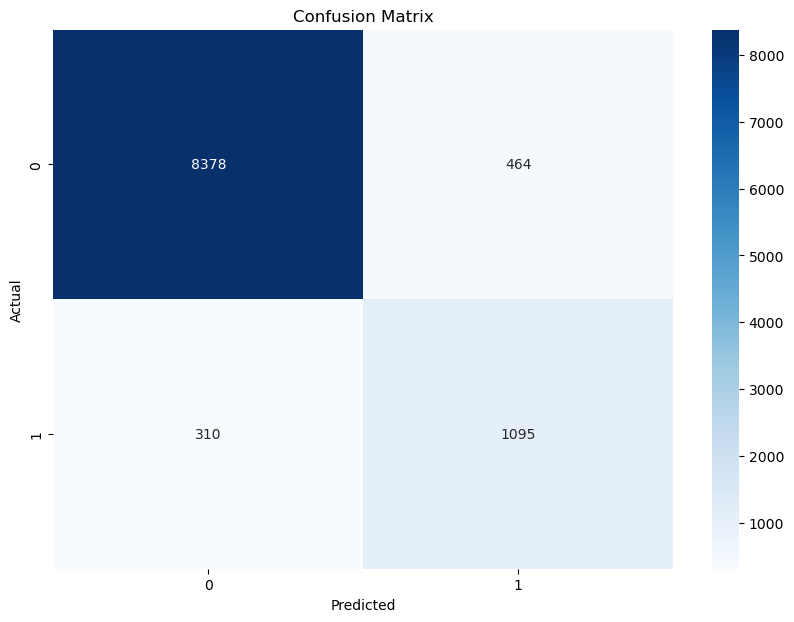

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

seed = 1
torch.manual_seed(seed)
## choose GPU id
gpu_id = 1 ## 1, 2, 3,4
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device('cuda', gpu_id)
else:
    device = torch.device('cpu')
print("device: ", device)
## random seed for cuda
if use_cuda:
    torch.cuda.manual_seed(72)
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_id, (x_batch, y_labels) in enumerate(test_loader):
        # Move data to GPU
        x_batch, y_labels = x_batch.to(device), y_labels.to(device)

        # Predict
        output_y,_= model(x_batch)

        # Binarize predictions
        y_pred= (output_y > 0.5).float()
        y_pred = y_pred.view(-1)

        # Store predictions and labels
        all_predictions.extend(y_pred.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(y_labels.cpu().numpy())  # Move to CPU and convert to numpy

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions)
print(f'F1 Score: {f1}')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()